# Key level and day fibonacci retracement - Analytics

### Import Library

In [35]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [36]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [37]:
data = dataset.copy()

In [38]:
data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-05-01 00:00:00')]

In [39]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-04-26 14:15:00,1229.9,1230.5,1227.3,1229.4,7567
2024-04-26 14:20:00,1229.8,1235.9,1229.4,1232.4,15934
2024-04-26 14:25:00,1232.5,1236.5,1232.1,1232.1,13075


In [40]:
day_data = data.resample('D').agg({
        'Close': 'last',
        'High': 'max',
        'Low': 'min'
    })
day_data.dropna(subset=['Close'], inplace=True)
day_data['prev_day_high'] = day_data['High'].shift(1)
day_data['prev_day_low'] = day_data['Low'].shift(1)
day_data = day_data[['prev_day_high', 'prev_day_low']]

In [41]:
data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")

In [42]:
def cal_price_position(row):
    if row['High'] - max(row['Open'], row['Close']) > min(row['Open'], row['Close']) - row['Low']:
        # upper wick > lower wick
        return (row['High'] - row['prev_day_low']) / (row['prev_day_high'] - row['prev_day_low'])
    else:
        # upper wick <= lower wick
        return (row['prev_day_low'] - row['Low']) / (row['prev_day_high'] - row['prev_day_low'])
data['price_pos'] = data.apply(lambda row: cal_price_position(row), axis=1)

In [43]:
back_bar = 10
next_bar = back_bar -1
data['max_prev'] = data['High'].rolling(back_bar).max()
data['max_next'] = data['High'].shift(-next_bar).rolling(back_bar).max()
data['min_prev'] = data['Low'].rolling(back_bar).min()
data['min_next'] = data['Low'].shift(-next_bar).rolling(back_bar).min()

In [44]:
data.dropna(inplace=True)
data['is_r_keylevel'] = data.apply(lambda r: True if (r['High'] == r['max_prev'] and r['High'] == r['max_next']) else False, axis=1)
data['is_s_keylevel'] = data.apply(lambda r: True if (r['Low'] == r['min_prev'] and r['Low'] == r['min_next']) else False, axis=1)
data

,Open,High,Low,Close,Volume,time_d,prev_day_high,prev_day_low,price_pos,max_prev,max_next,min_prev,min_next,is_r_keylevel,is_s_keylevel
Date,,,,,,,,,,,,,,,
2020-11-03 09:00:00,909.3,909.4,908.5,908.8,1435,2020-11-03,907.0,895.4,-1.129310,909.4,909.4,896.6,907.4,True,False
2020-11-03 09:05:00,908.6,908.9,908.6,908.8,1360,2020-11-03,907.0,895.4,1.163793,909.4,908.9,896.6,907.4,False,False
2020-11-03 09:10:00,908.8,908.8,908.2,908.6,1159,2020-11-03,907.0,895.4,-1.103448,909.4,908.9,896.6,907.4,False,False
2020-11-03 09:15:00,908.6,908.9,908.3,908.5,1355,2020-11-03,907.0,895.4,1.163793,909.4,908.9,896.6,907.4,False,False
2020-11-03 09:20:00,908.5,908.8,908.1,908.1,847,2020-11-03,907.0,895.4,1.155172,909.4,908.8,897.4,907.4,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26 13:30:00,1231.3,1232.8,1228.1,1228.1,10045,2024-04-26,1230.5,1221.3,1.250000,1234.0,1232.8,1226.5,1225.1,False,False
2024-04-26 13:35:00,1228.0,1228.8,1225.1,1228.5,11359,2024-04-26,1230.5,1221.3,-0.413043,1232.8,1235.9,1225.1,1225.1,False,True
2024-04-26 13:40:00,1229.1,1230.2,1228.6,1229.0,5461,2024-04-26,1230.5,1221.3,0.967391,1232.8,1236.5,1225.1,1226.1,False,False


In [45]:
keylevel_data = data[(data['is_r_keylevel'] == True) | (data['is_s_keylevel'] == True)]
len(keylevel_data)

3289

In [46]:
top_data = data[data['is_r_keylevel'] == True]
bot_data = data[data['is_s_keylevel'] == True]
rac_data = data[(data['is_r_keylevel'] != True) & (data['is_s_keylevel'] != True)]

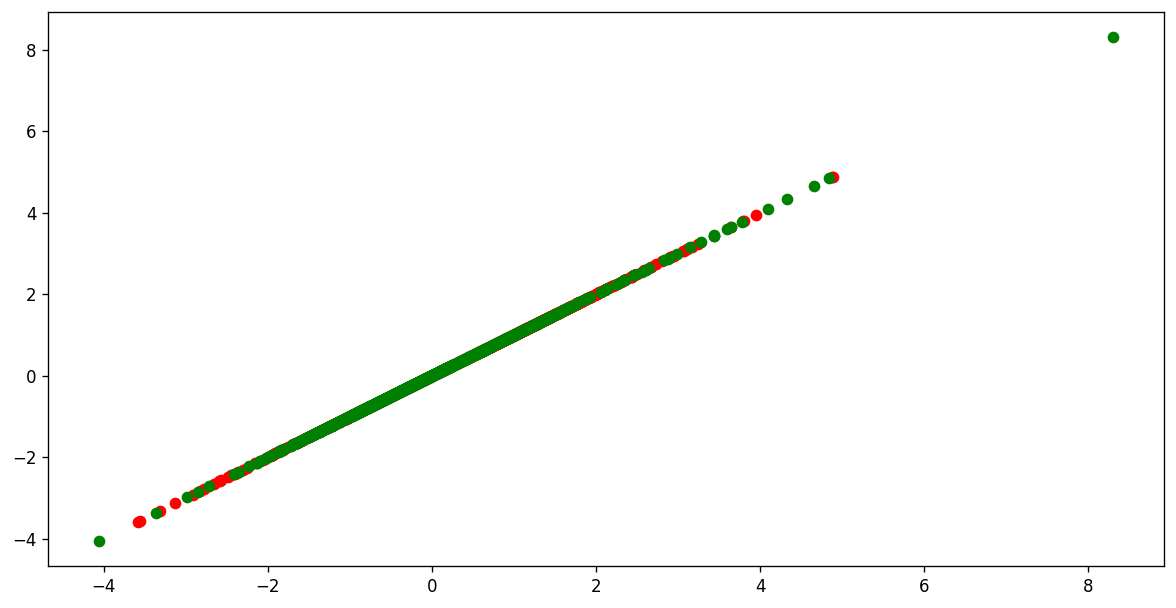

In [50]:
plt.scatter(top_data['price_pos'], top_data['price_pos'], c='red')
plt.scatter(bot_data['price_pos'], bot_data['price_pos'], c='green')
# plt.scatter(rac_data['price_pos'], rac_data['price_pos'], c='yellow')